# Análisis Exploratorio &rarr; Tabla Ingresos

En este notebook se creó un análisis inicial a la tabla ingresos, con el fin de encontrar patrones en las ventas del negocio. También sirvió para mejorar la pipeline, especialmente la etapa de transformación de datos.

In [41]:
# Importe de librerías
import matplotlib.pyplot as plt
import os
import pandas as pd
from datetime import timedelta
from dotenv import load_dotenv

In [42]:
# Carga de archivo

load_dotenv()
PATH = os.getenv('RUTA_INGRESOS')

df = pd.read_csv(PATH)
df['Fecha'] = pd.to_datetime(df['Fecha'])
df.head(5)

,Boleta,Fecha,Cantidad,Precio,Descuento,Total,Tipo,id_cliente,id_producto,id_acompañamiento,id_extra,Año,Mes,Trimestre,MesNombre,Semana,Dia,DiaAño,DiaSemana
0,0,2022-07-02,1.0,4000.0,0,4000.0,ALMUERZOS,0,65.0,0,0,2022,7,3,Jul,26,2,183,Saturday
1,1,2022-07-02,1.0,4000.0,0,4000.0,ALMUERZOS,1,65.0,0,0,2022,7,3,Jul,26,2,183,Saturday
2,1,2022-07-02,1.0,4000.0,0,4000.0,ALMUERZOS,1,60.0,1,1,2022,7,3,Jul,26,2,183,Saturday
3,2,2022-07-02,2.0,4000.0,0,8000.0,ALMUERZOS,2,65.0,2,0,2022,7,3,Jul,26,2,183,Saturday
4,3,2022-07-03,3.0,4000.0,0,12000.0,ALMUERZOS,3,6.0,3,0,2022,7,3,Jul,26,3,184,Sunday


## Información de los datos

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2471 entries, 0 to 2470
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Boleta             2471 non-null   int64         
 1   Fecha              2471 non-null   datetime64[ns]
 2   Cantidad           2471 non-null   float64       
 3   Precio             2470 non-null   float64       
 4   Descuento          2231 non-null   object        
 5   Total              2470 non-null   float64       
 6   Tipo               2471 non-null   object        
 7   id_cliente         2471 non-null   int64         
 8   id_producto        2471 non-null   float64       
 9   id_acompañamiento  2471 non-null   int64         
 10  id_extra           2471 non-null   int64         
 11  Año                2471 non-null   int64         
 12  Mes                2471 non-null   int64         
 13  Trimestre          2471 non-null   int64         
 14  MesNombr

In [44]:
'''
De la ejecución anterior se puede apreciar que existe un total de 2470 filas y en las columnas Precio, Descuento y Total existen nulos, por lo que, 
a continuación se desarrollaran distintos métodos para reemplazar los nulos de las columnas mencionadas.
'''

df1 = df[ (df['Descuento'].isna()) |  (df['Total'].isna()) | (df['Precio'].isna())].copy() # subconsulta con los nulos

df_precios_na = df1[(df1['Precio'].isna())]
df_dsctos_na = df1[(df1['Descuento'].isna())]
df_total_na = df1[(df1['Total'].isna())]

In [45]:
df_precios_na

,Boleta,Fecha,Cantidad,Precio,Descuento,Total,Tipo,id_cliente,id_producto,id_acompañamiento,id_extra,Año,Mes,Trimestre,MesNombre,Semana,Dia,DiaAño,DiaSemana
2322,1510,2023-05-31,6.0,NaN,NaN,0.0,OTROS,35,174.0,3,3,2023,5,2,May,22,31,151,Wednesday


In [46]:
# Algoritmo de arreglo para precios nulos

'''
Para reemplazar los precios nulos, se creará un algoritmo que buscará los precios más paracidos en un rango de una semana,
se debe coincidir las cantidad de productos vendidos, si existe más de un precio en el rango de fechas, se utilizará el promedio,
en caso contrario, se utilizará el precio único. 
'''

def calcular_precios_cercanos(df, columna_precio):
    precios = df[columna_precio].to_list()
    precios = [precio for precio in precios if precio > 0]

    if len(precios) > 1:
        return sum(precios)/len(precios)
    
    elif len(precios) == 1:
        return precios[0]

    else: 
        # Buscar rangos de fechas más largos
        return 0
    

df2 = df_precios_na.copy()
indices_precios_na = df2.index.to_list()
cantidades = df2.loc[indices_precios_na, 'Cantidad'].to_list()
productos = df2.loc[indices_precios_na, 'id_producto'].to_list()

datos = []

for i in range(len(productos)):
    df3 = df2[(df2['id_producto']==productos[i])]
    indice = df3.index.to_list()
    
    fecha = df2.loc[indice, 'Fecha'].to_list()
    fecha_min = fecha[0] - timedelta(7)
    fecha_max = fecha[0] + timedelta(7)

    df4 = df.copy()

    condicion1 = df4['id_producto'].isin(productos)
    condicion2 = df4['Fecha'] > fecha_min
    condicion3 = df4['Fecha'] < fecha_max
    condicion4 = df4['Cantidad'].isin(cantidades)

    df4 = df4[(condicion1) & (condicion2) & (condicion3) & (condicion4)]
    precio_final = 0

    if df4.empty:
        df4 = df.copy()
        df4 = df4[(condicion1) & (condicion2) & (condicion3)]

        precio_final = calcular_precios_cercanos(df4, 'Precio')

    else:
        precio_final = calcular_precios_cercanos(df4, 'Precio')

    datos.append({
            'Indice':indice[0],
            'id_producto': productos[i],
            'Precio': precio_final
        })

datos = pd.DataFrame(datos)
datos = datos.set_index('Indice')

df1.loc[datos.index.to_list(), ['Principal-Producto', 'Precio']] = datos

print('Precios nulos corregidos')
df1.loc[datos.index, :]

Precios nulos corregidos


,Boleta,Fecha,Cantidad,Precio,Descuento,Total,Tipo,id_cliente,id_producto,id_acompañamiento,id_extra,Año,Mes,Trimestre,MesNombre,Semana,Dia,DiaAño,DiaSemana,Principal-Producto
Indice,,,,,,,,,,,,,,,,,,,,
2322,1510,2023-05-31,6.0,466.7,NaN,0.0,OTROS,35,174.0,3,3,2023,5,2,May,22,31,151,Wednesday,NaN


In [47]:
# Descuentos y Total nulos

''' En este df existe un error particular, donde un dato después del numero viene un }, así que este error será reemplazado y los otros nulos 
    serán reemplazados por 0. Por otro lado, la columna total tiene un único valor nulo que tiene relación con el dato de dscto con }.
'''
df1.loc[:,('Descuento')] = df1.loc[:, ('Descuento')].str.replace('}', '', regex=True)
df1['Descuento'] = df1['Descuento'].fillna(0)

df1['Descuento'] = df1['Descuento'].astype(float)

df1['Total'] = (df1['Cantidad'] * df1['Precio']) - df1['Descuento']


In [48]:
# reemplazar valores df1 en df

df.loc[df1.index.to_list(), :] = df1

df['Descuento'] = df['Descuento'].astype(float)
df['id_cliente'] = df['id_cliente'].astype(str)
df['id_producto'] = df['id_producto'].astype(str)
df['id_acompañamiento'] = df['id_acompañamiento'].astype(str)
df['id_extra'] = df['id_extra'].astype(str)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2471 entries, 0 to 2470
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Boleta             2471 non-null   int64         
 1   Fecha              2471 non-null   datetime64[ns]
 2   Cantidad           2471 non-null   float64       
 3   Precio             2471 non-null   float64       
 4   Descuento          2471 non-null   float64       
 5   Total              2471 non-null   float64       
 6   Tipo               2471 non-null   object        
 7   id_cliente         2471 non-null   object        
 8   id_producto        2471 non-null   object        
 9   id_acompañamiento  2471 non-null   object        
 10  id_extra           2471 non-null   object        
 11  Año                2471 non-null   int64         
 12  Mes                2471 non-null   int64         
 13  Trimestre          2471 non-null   int64         
 14  MesNombr

## Descripción de los datos

In [49]:
df.describe()

,Boleta,Fecha,Cantidad,Precio,Descuento,Total,Año,Mes,Trimestre,Semana,Dia,DiaAño
count,2471.000000,2471,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000,2471.000000
mean,810.205585,2023-07-25 18:42:23.747470592,1.851882,4754.723837,6.475111,6402.928207,2022.985836,7.485229,2.810603,30.499798,15.532983,211.949413
min,0.000000,2022-07-02 00:00:00,1.000000,300.000000,0.000000,1000.000000,2022.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,408.500000,2023-05-12 00:00:00,1.000000,5000.000000,0.000000,5000.000000,2023.000000,5.000000,2.000000,20.000000,8.000000,139.500000
50%,817.000000,2023-08-09 00:00:00,1.000000,5000.000000,0.000000,5000.000000,2023.000000,8.000000,3.000000,32.000000,15.000000,219.000000
75%,1213.000000,2023-10-22 00:00:00,2.000000,5000.000000,0.000000,6000.000000,2023.000000,10.000000,4.000000,42.000000,23.000000,294.000000
max,1633.000000,2024-01-05 00:00:00,36.000000,7500.000000,1000.000000,69600.000000,2024.000000,12.000000,4.000000,52.000000,31.000000,365.000000
std,463.988459,NaN,2.817512,1235.799667,80.223368,3458.156114,0.215309,3.195848,1.050807,13.999910,8.916551,97.916292


In [188]:
def indicadores_df(df, periodo_tiempo, Categorizar=False, fecha_inicio=None, fecha_fin=None):
    
    # Definir valores predeterminados para fecha_inicio y fecha_fin si no se proporcionan
    if fecha_inicio is None:
        fecha_inicio = df['Fecha'].min()
    if fecha_fin is None:
        fecha_fin = df['Fecha'].max()

    # Definir columnas a filtrar y a agrupar
    filtrar = [periodo_tiempo, 'Total', 'id_cliente', 'Boleta', 'Cantidad', 'id_producto']
    agrupar = [periodo_tiempo]

    # Actualizar si se va a categorizar
    if Categorizar:
        agrupar.append('Categoria')
        filtrar.append('Categoria')

    # Filtrar el DataFrame
    df_filtrado = df[(df['Fecha'] >= fecha_inicio) & (df['Fecha'] <= fecha_fin)]
    
    # Realizar agrupación y cálculos de indicadores
    df_indicadores = df_filtrado[filtrar].groupby(agrupar).agg({
        'Total': 'sum',
        'id_cliente': 'nunique',
        'Boleta': 'nunique',
        'Cantidad': 'sum',
        'id_producto': 'nunique'
    })

    # Renombrar columnas
    df_indicadores = df_indicadores.rename(columns={'id_cliente': 'N°_Clientes', 'id_producto': 'N°_Productos'})

    # Calcular indicadores adicionales
    df_indicadores['Ticket_Promedio'] = df_indicadores['Total'] / df_indicadores['Boleta']
    df_indicadores['Productos_Boleta'] = df_indicadores['Cantidad'] / df_indicadores['Boleta']
    df_indicadores['Gasto_Cliente'] = df_indicadores['Total'] / df_indicadores['N°_Clientes']

    # Resetear el índice para obtener una estructura de DataFrame más plana
    return df_indicadores.reset_index()

def graficar_indicadores(df_indicadores, periodo_tiempo):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))

    ax1.plot(df_indicadores[periodo_tiempo], df_indicadores['Total']/1000000.0, color='red', marker='o')
    ax1.set_title(f'Ingresos por {periodo_tiempo}')
    ax1.set_xlabel(f'{periodo_tiempo}')
    ax1.set_ylabel('Ingresos (Mill)')

    ax2.plot(df_indicadores[periodo_tiempo], df_indicadores['Ticket_Promedio'], color='blue')
    ax2.set_title(f'Ticket Promedio por {periodo_tiempo}')
    ax2.set_xlabel(f'{periodo_tiempo}')
    ax2.set_ylabel('Ticket Promedio')

    ax3.plot(df_indicadores[periodo_tiempo], df_indicadores['N°_Clientes'], color='green')
    ax3.set_title(f'Número de Clientes por {periodo_tiempo}')
    ax3.set_xlabel(f'{periodo_tiempo}')
    ax3.set_ylabel('Clientes')

    plt.tight_layout()
    plt.show()





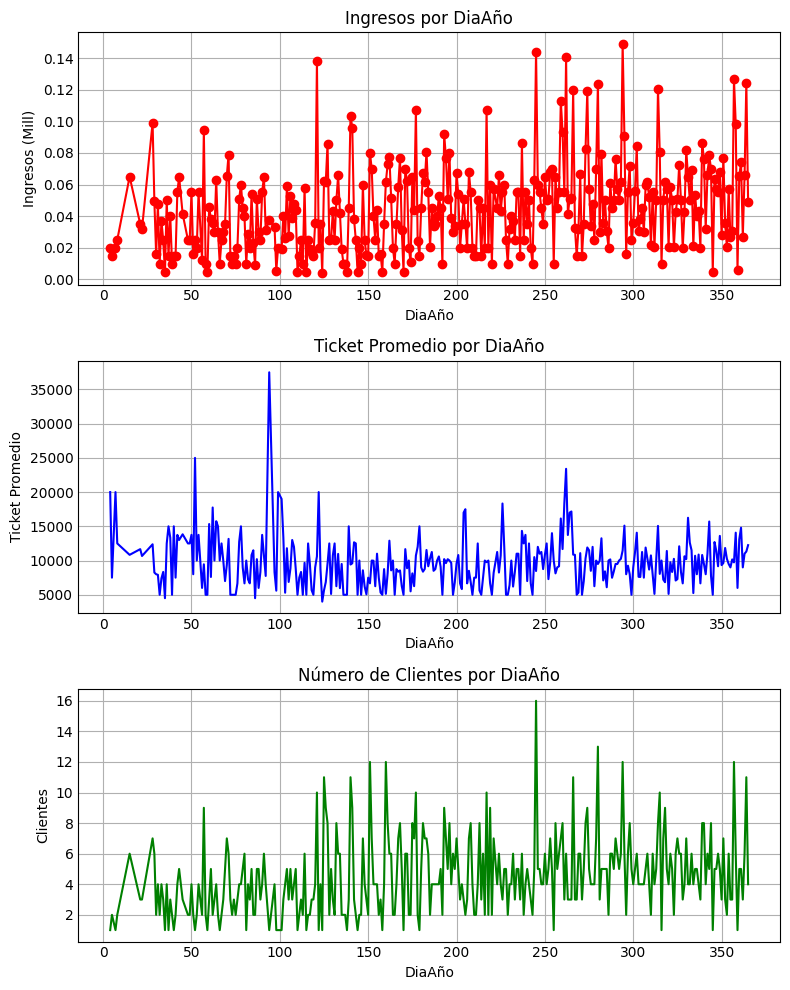

In [193]:
# Mostrar indicadores Diarios 2023

periodo_tiempo = 'DiaAño'
fecha_inicio = '2023-01-01'
fecha_fin = '2023-12-31'

df_indicadores = indicadores_df(df, periodo_tiempo, False, fecha_inicio, fecha_fin)
graficar_indicadores(df_indicadores, periodo_tiempo)



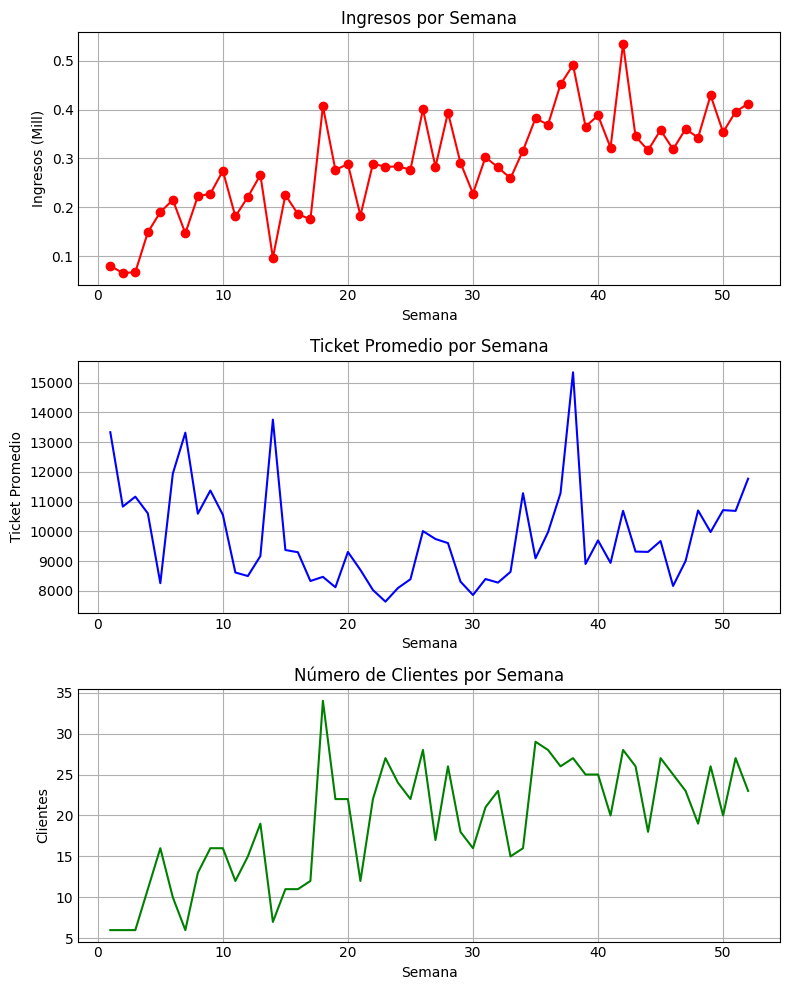

In [192]:
# Mostrar indicadores Semanales 2023

periodo_tiempo = 'Semana'
fecha_inicio = '2023-01-01'
fecha_fin = '2023-12-31'

df_indicadores = indicadores_df(df, periodo_tiempo, False, fecha_inicio, fecha_fin)
graficar_indicadores(df_indicadores, periodo_tiempo)


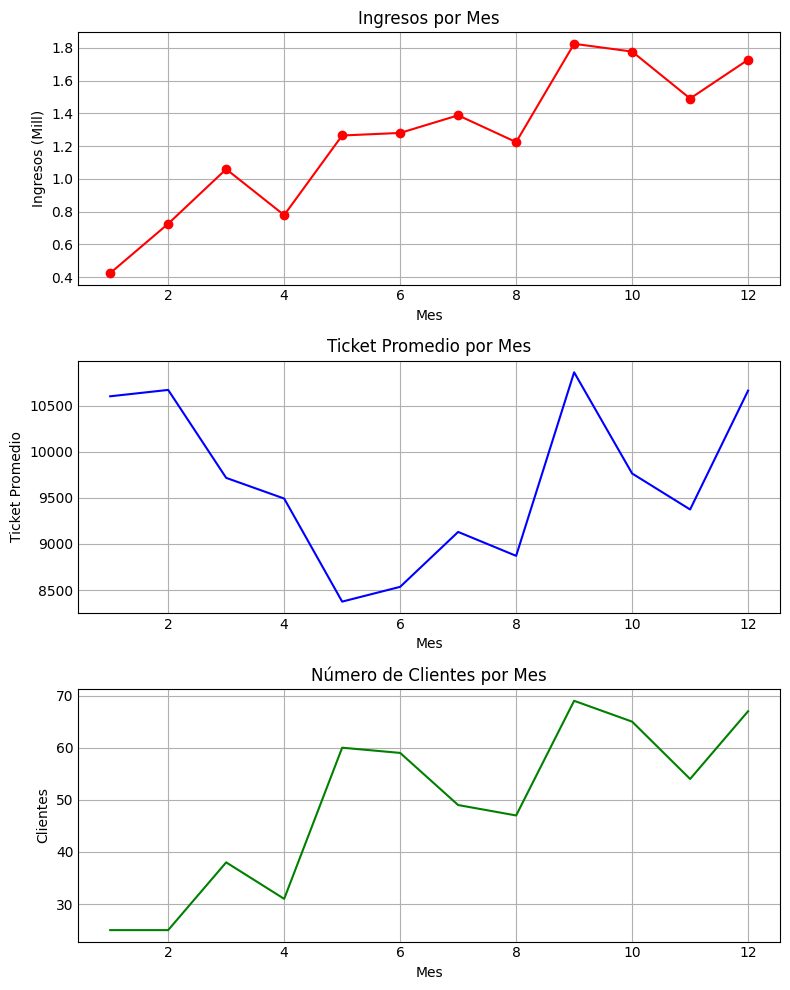

In [191]:
# Mostrar indicadores Mensuales 2023

periodo_tiempo = 'Mes'
fecha_inicio = '2023-01-01'
fecha_fin = '2023-12-31'

df_indicadores = indicadores_df(df, periodo_tiempo, False, fecha_inicio, fecha_fin)
graficar_indicadores(df_indicadores, periodo_tiempo)
